# Spatiotemporal CNN-RNN Proxy Model for CO2 Monitoring
### Misael M. Morales, The University of Texas at Austin
Morales, M.M., Torres-Verdin, C., and Pyrcz, M. J. (2023) Stochastic pix2vid: A new spatiotemporal deep learning method for image-to-video synthesis in geologic CO2 storage prediction
***

In [2]:
from utils import *
check_tensorflow_gpu()

proxy = SpatiotemporalCO2()

... Checking Tensorflow Version ...
Tensorflow built with CUDA? True
TF: 2.10.0 | CUDA: 64_112 | cuDNN: 64_8
# GPU available: 1 (NVIDIA GeForce RTX 3080)
--------------------------------------


In [3]:
proxy.load_data()
proxy.process_data()

... Loading Full Dataset ...
X: (1000, 64, 64, 4) | y: (1000, 60, 64, 64, 2)
Data Augmentation Done!    - n_samples=2,000
MinMax Normalization Done! - [0.0, 1.0]
Train - X: (1500, 64, 64, 4) | y: (1500, 11, 64, 64, 2)
Test  - X: (500, 64, 64, 4)  | y: (500, 11, 64, 64, 2)


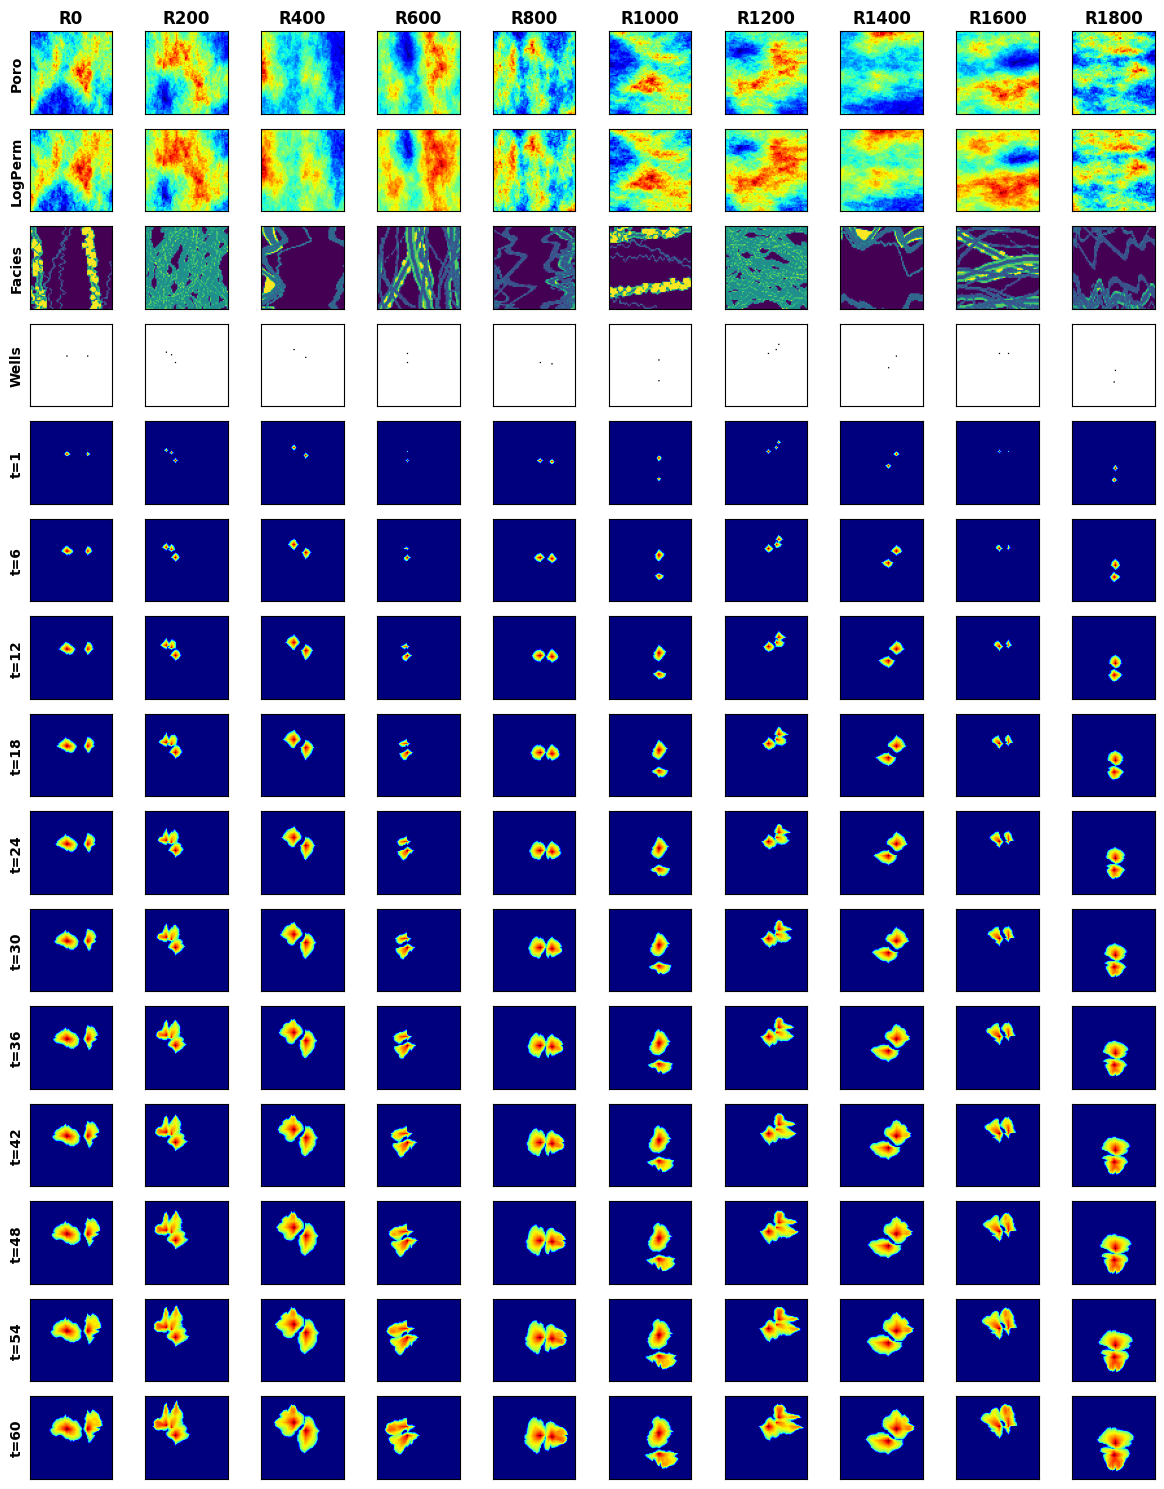

In [4]:
proxy.plot_data()
#proxy.plot_features(); proxy.plot_targets()

In [5]:
proxy.make_model()

In [6]:
#proxy.training()
proxy.model.load_weights('model_weights.h5')

In [7]:
proxy.predictions()

16/16 [==============================] - 3s 209ms/step
Train pred: (1500, 11, 64, 64, 2) | Test pred: (500, 11, 64, 64, 2)
MSE  | Train: 9.41e-04, Test: 9.09e-04
SSIM | Train: 96.94, Test: 97.00


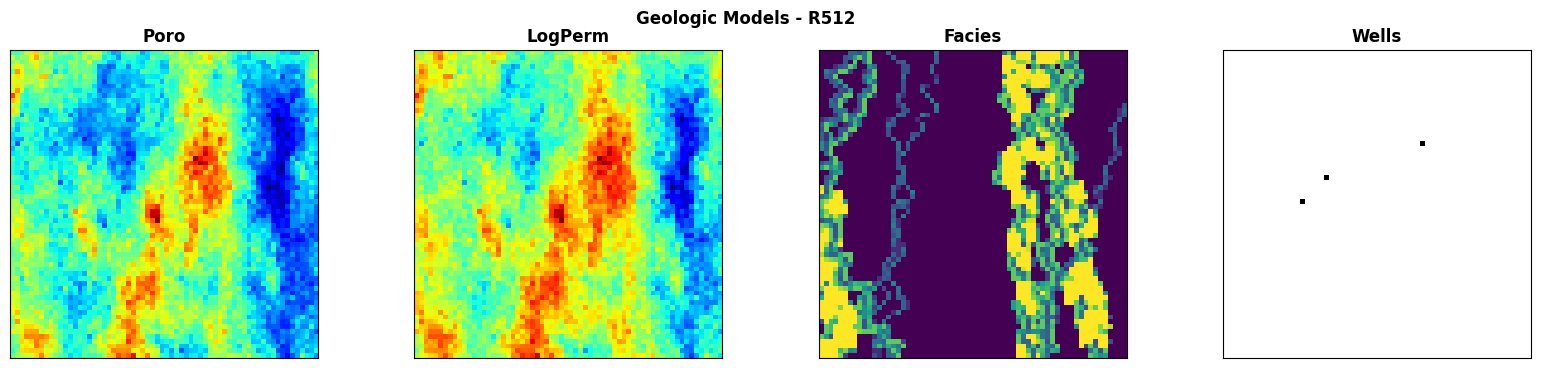

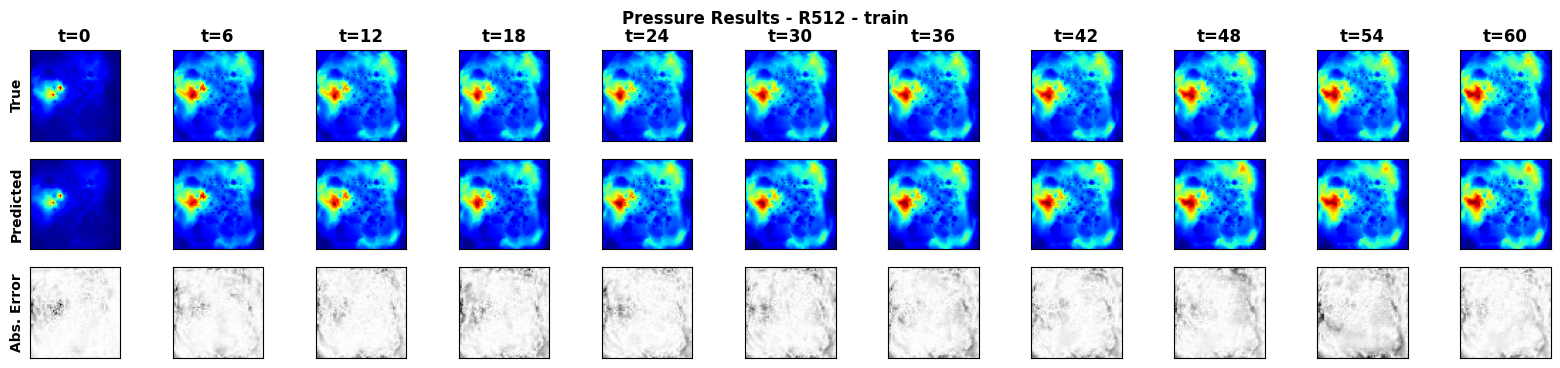

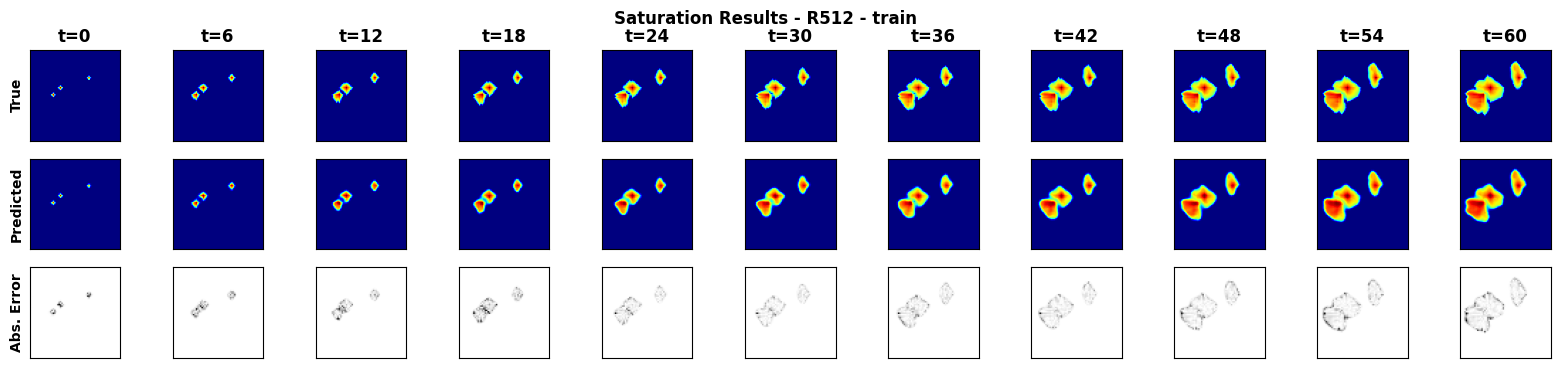

In [8]:
proxy.plot_single_results(512, 'train')

Train - Mean CO2 Injected: True: 4796.90 | Pred: 4840.58
Test  - Mean CO2 Injected: True: 4691.78 | Pred: 4723.27


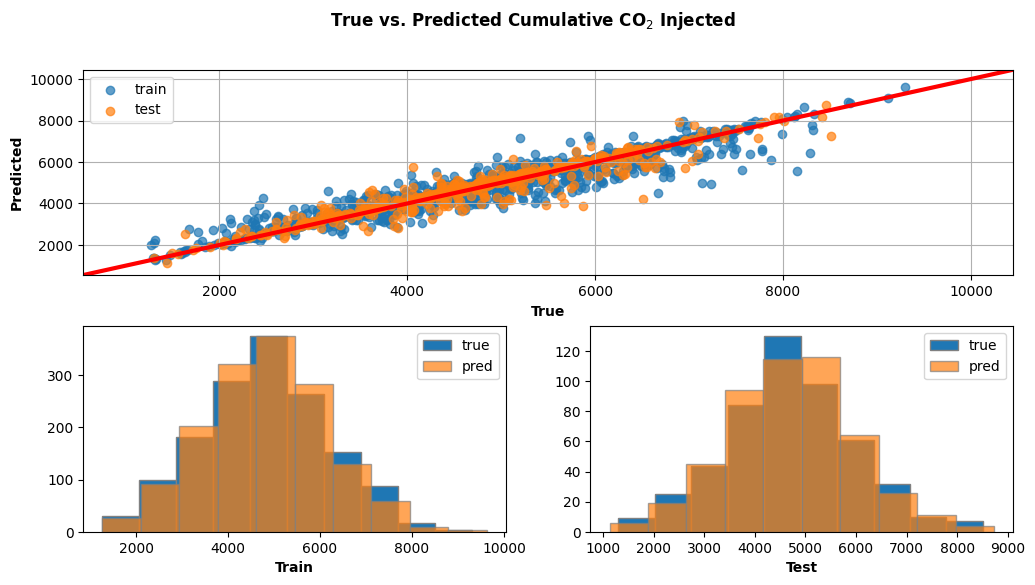

In [9]:
proxy.cumulative_co2()

***
# END